# Attempt to validate finding of important variables for depression classification from mobile health data
- attempted validation of findings published in JAMIA Jan 24 2020 -- [Depression screening using mobile phone usage metadata: a machine learning approach](https://academic.oup.com/jamia/advance-article/doi/10.1093/jamia/ocz221/5715569)

In [1]:
import pandas as pd
import os, json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any, Dict, List

subject_data_dir = '/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data'
files = os.listdir(subject_data_dir)
file_paths = [os.path.join(subject_data_dir, f) for f in files if f[0] == 'm']


In [2]:
data_list = []

for f in file_paths:
    data_list.append(pd.read_excel(f))

In [3]:
data = pd.concat(data_list, sort=False)

In [4]:
print(data.columns.tolist())

['subject_id', 'Date', 'Calories (kcal)', 'Distance (mi)', 'Average heart rate (bpm)', 'Max heart rate (bpm)', 'Min heart rate (bpm)', 'Step count', 'swtype', 'device_id_call', 'total_calls', 'incoming_calls', 'outgoing_calls', 'ratio_of_outgoing_calls', 'device_id_message', 'received_message', 'sent_message', 'total_messages', 'ratio_of_sent_messages', 'device_id_app', 'social_app', 'mail_app', 'total_app', 'social_mail_app_ratio', 'call_time_1', 'transcription_1', 'dgc_transcription_1', 'recording_duration_1', 'call_time_2', 'transcription_2', 'dgc_transcription_2', 'recording_duration_2', 'call_time_3', 'transcription_3', 'dgc_transcription_3', 'recording_duration_3', 'call_time_4', 'transcription_4', 'dgc_transcription_4', 'recording_duration_4', 'mbrep_start_date_1', 'mbrep_start_loc_1', 'mbrep_start_loc_other_1', 'mbrep_duration_reformat_1', 'mbrep_duration_1', 'mbrep_pain_level_1', 'mbrep_activities_1', 'mbrep_activities_other_1', 'mbrep_triggers_1', 'mbrep_triggers_other_1', 'm

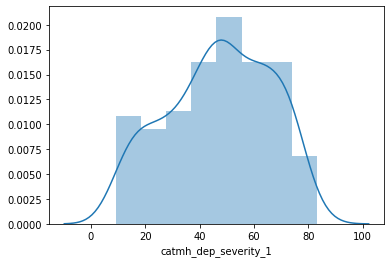

In [23]:
sns.distplot(
    data['catmh_dep_severity_1']
)

In [33]:
data.mbrep_relief_1.dropna()
data['migraine_treat_relief'] = data.mbrep_relief_1.str.split('-').str[0].str.strip().str.lower()
data['migraine_treat_relief'].unique()
relief_val_dict = {
    'unhelpful': -1,
    'no relief': 0,
    'somewhat helpful': 1,
    'helpful': 2,
}
data['migraine_treat_relief_num'] = data['migraine_treat_relief'].map(relief_val_dict)
data.groupby('migraine_treat_relief_num').Date.count()

migraine_treat_relief_num
-1.0     3
 0.0    32
 1.0    58
 2.0    70
Name: Date, dtype: int64

Text(0.5, 0.98, 'r: 0.1184 p: 0.1323')

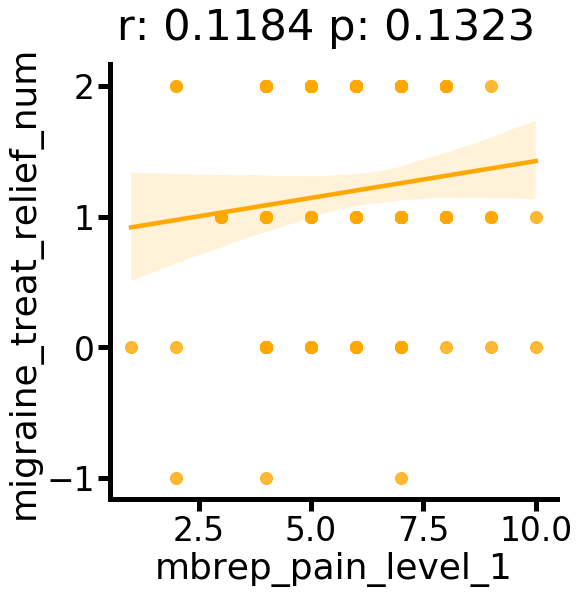

In [37]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(8,8))
sns.set_context(
    'poster',
    font_scale=1.5,
    rc={
        'axes.linewidth': 5,
        'xtick.major.width': 5,
        'ytick.major.width': 5,       
    }
)
no_na_rol = data[['mbrep_pain_level_1', 'migraine_treat_relief_num']].dropna()
r, p = stats.pearsonr(no_na_rol['mbrep_pain_level_1'], no_na_rol['migraine_treat_relief_num'])
sns.regplot(
    data=data,
    x='mbrep_pain_level_1',
    y='migraine_treat_relief_num',
    ax=ax,
    color=palette['mbrep_pain_level_1']
)
sns.despine()
ax.set_ylabel('migraine_treat_relief_num') # (10 Day Rolling Average Before Score)
ax.set_xlabel('mbrep_pain_level_1')
plt.suptitle('r: ' + str(round(r,4)) + ' p: ' + str(round(p,4)))


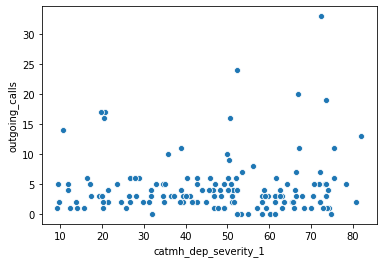

In [17]:
import numpy as np
sns.scatterplot(
    data=data,
    x='catmh_dep_severity_1',
    y='outgoing_calls'
)

In [27]:
with_rls = []
for subject, s_df in data.sort_values(by='Date').groupby('subject_id'):
    s_df['avg_calls'] = s_df['outgoing_calls'].rolling(10).mean()
    with_rls.append(s_df)
rol_df = pd.concat(with_rls, sort=False)

/Users/akre96/Code/DGC_Study/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'r: -0.0572 p: 0.6869')

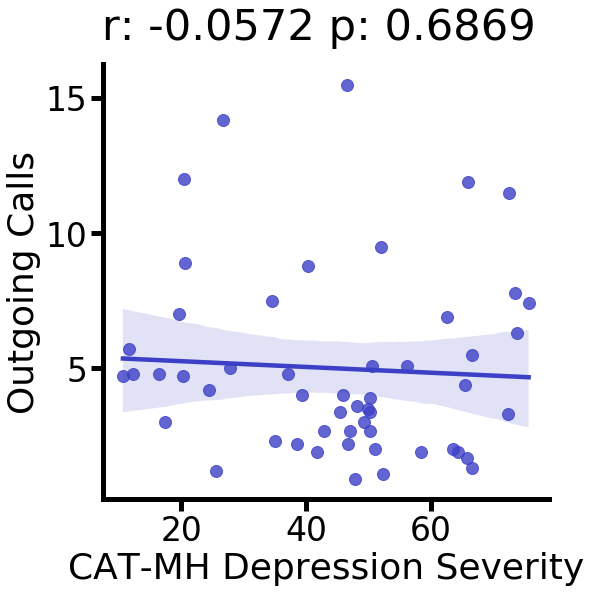

In [68]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(8,8))
sns.set_context(
    'poster',
    font_scale=1.5,
    rc={
        'axes.linewidth': 5,
        'xtick.major.width': 5,
        'ytick.major.width': 5,       
    }
)
no_na_rol = rol_df[['catmh_dep_severity_1', 'avg_calls']].dropna()
r, p = stats.pearsonr(no_na_rol['catmh_dep_severity_1'], no_na_rol['avg_calls'])
sns.regplot(
    data=rol_df,
    x='catmh_dep_severity_1',
    y='avg_calls',
    ax=ax,
    color=palette['catmh_dep_severity_1']
)
sns.despine()
ax.set_ylabel('Outgoing Calls') # (10 Day Rolling Average Before Score)
ax.set_xlabel('CAT-MH Depression Severity')
plt.suptitle('r: ' + str(round(r,4)) + ' p: ' + str(round(p,4)))


In [67]:
rol_df[['avg_calls', 'subject_id', 'catmh_dep_severity_1']].dropna().nunique()

avg_calls               39
subject_id              21
catmh_dep_severity_1    49
dtype: int64

In [9]:
with_rls = []
for subject, s_df in data.sort_values(by='Date').groupby('subject_id'):
    s_df['roll_avg_barom'] = s_df['average_barom_pressure'].rolling(3).mean()
    with_rls.append(s_df)
rol_df = pd.concat(with_rls, sort=False)

/Users/akre96/Code/DGC_Study/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/akre96/Code/DGC_Study/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


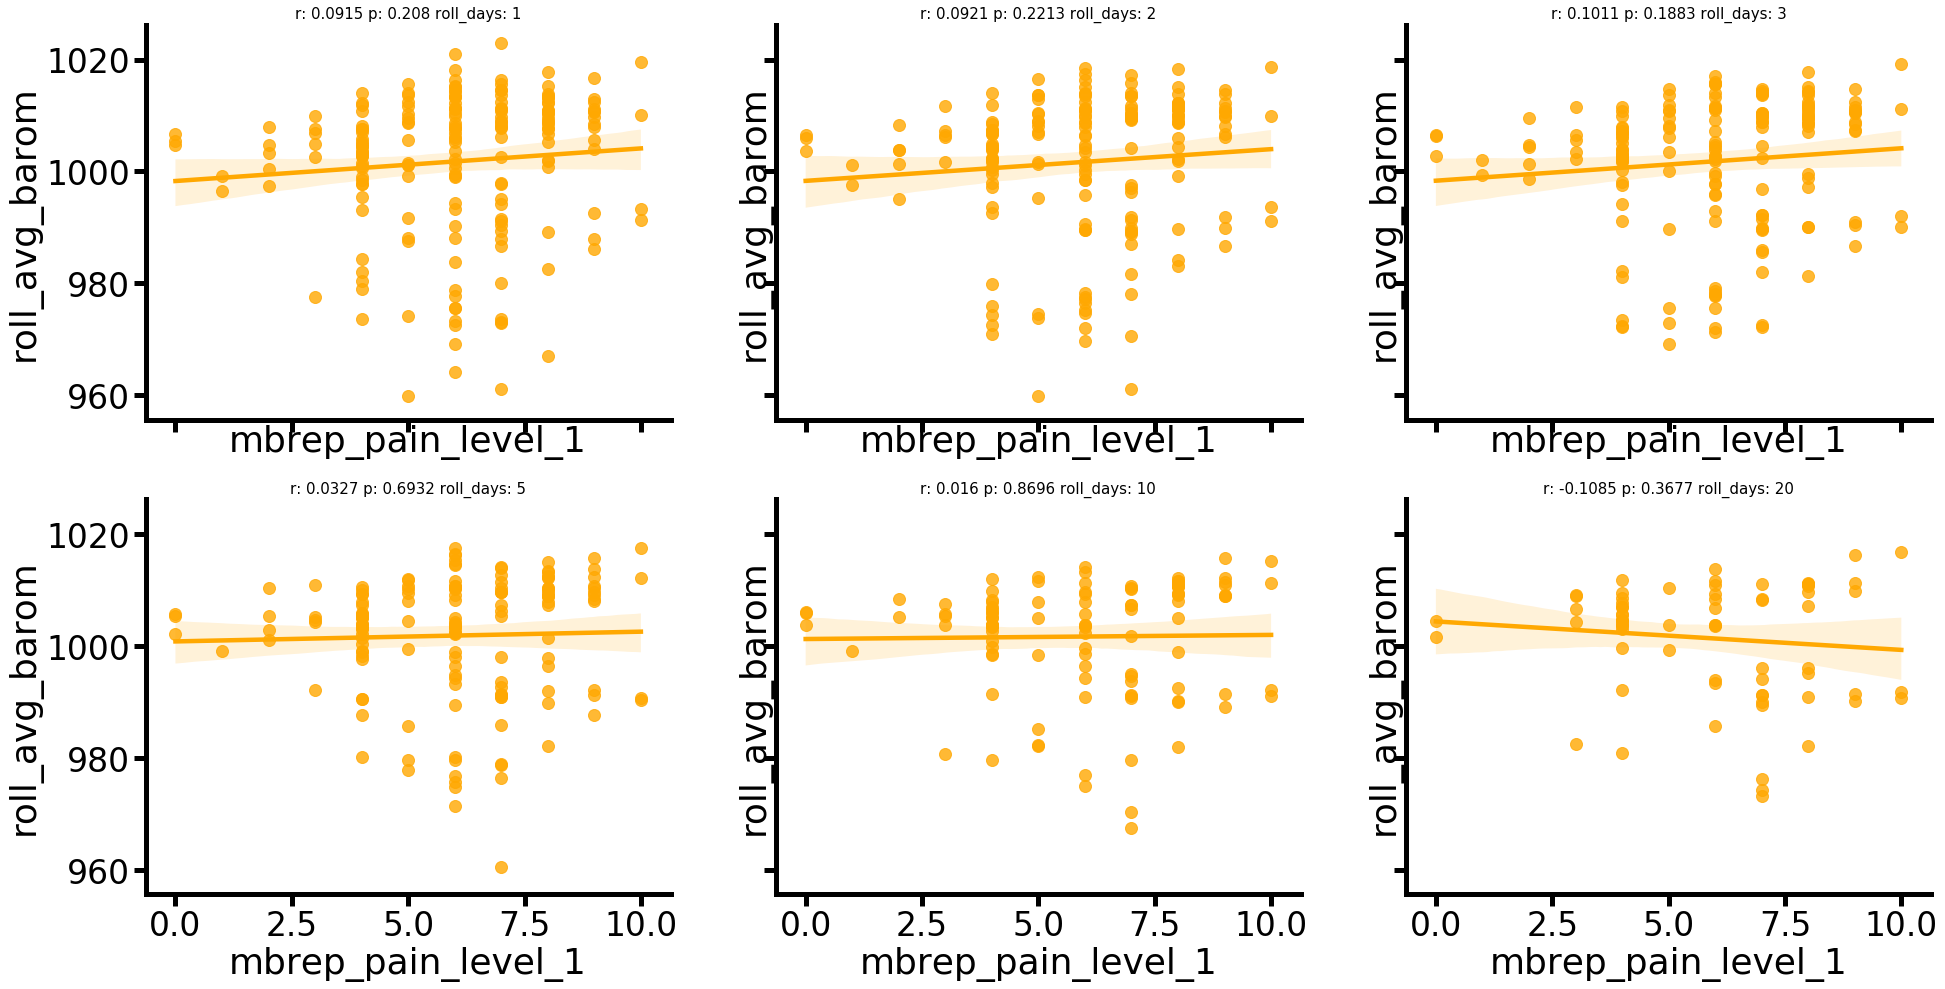

In [20]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(32, 16), sharex=True, sharey=True)
i=0
for roll_day in [1, 2, 3, 5, 10, 20]:
    with_rls = []
    for subject, s_df in data.sort_values(by='Date').groupby('subject_id'):
        s_df['roll_avg_barom'] = s_df['average_barom_pressure'].rolling(roll_day).mean()
        with_rls.append(s_df)
    rol_df = pd.concat(with_rls, sort=False)
    ax = axes.flatten()[i]
    sns.set_context(
        'poster',
        font_scale=1.5,
        rc={
            'axes.linewidth': 5,
            'xtick.major.width': 5,
            'ytick.major.width': 5,       
        }
    )
    no_na_rol = rol_df[['mbrep_pain_level_1', 'roll_avg_barom']].dropna()
    r, p = stats.pearsonr(no_na_rol['mbrep_pain_level_1'], no_na_rol['roll_avg_barom'])
    sns.regplot(
        data=rol_df,
        x='mbrep_pain_level_1',
        y='roll_avg_barom',
        ax=ax,
        color=palette['mbrep_pain_level_1']
    )
    sns.despine()
    ax.set_title('r: ' + str(round(r,4)) + ' p: ' + str(round(p,4)) + ' roll_days: ' + str(roll_day), fontsize=15)
    i += 1

/Users/akre96/Code/DGC_Study/venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


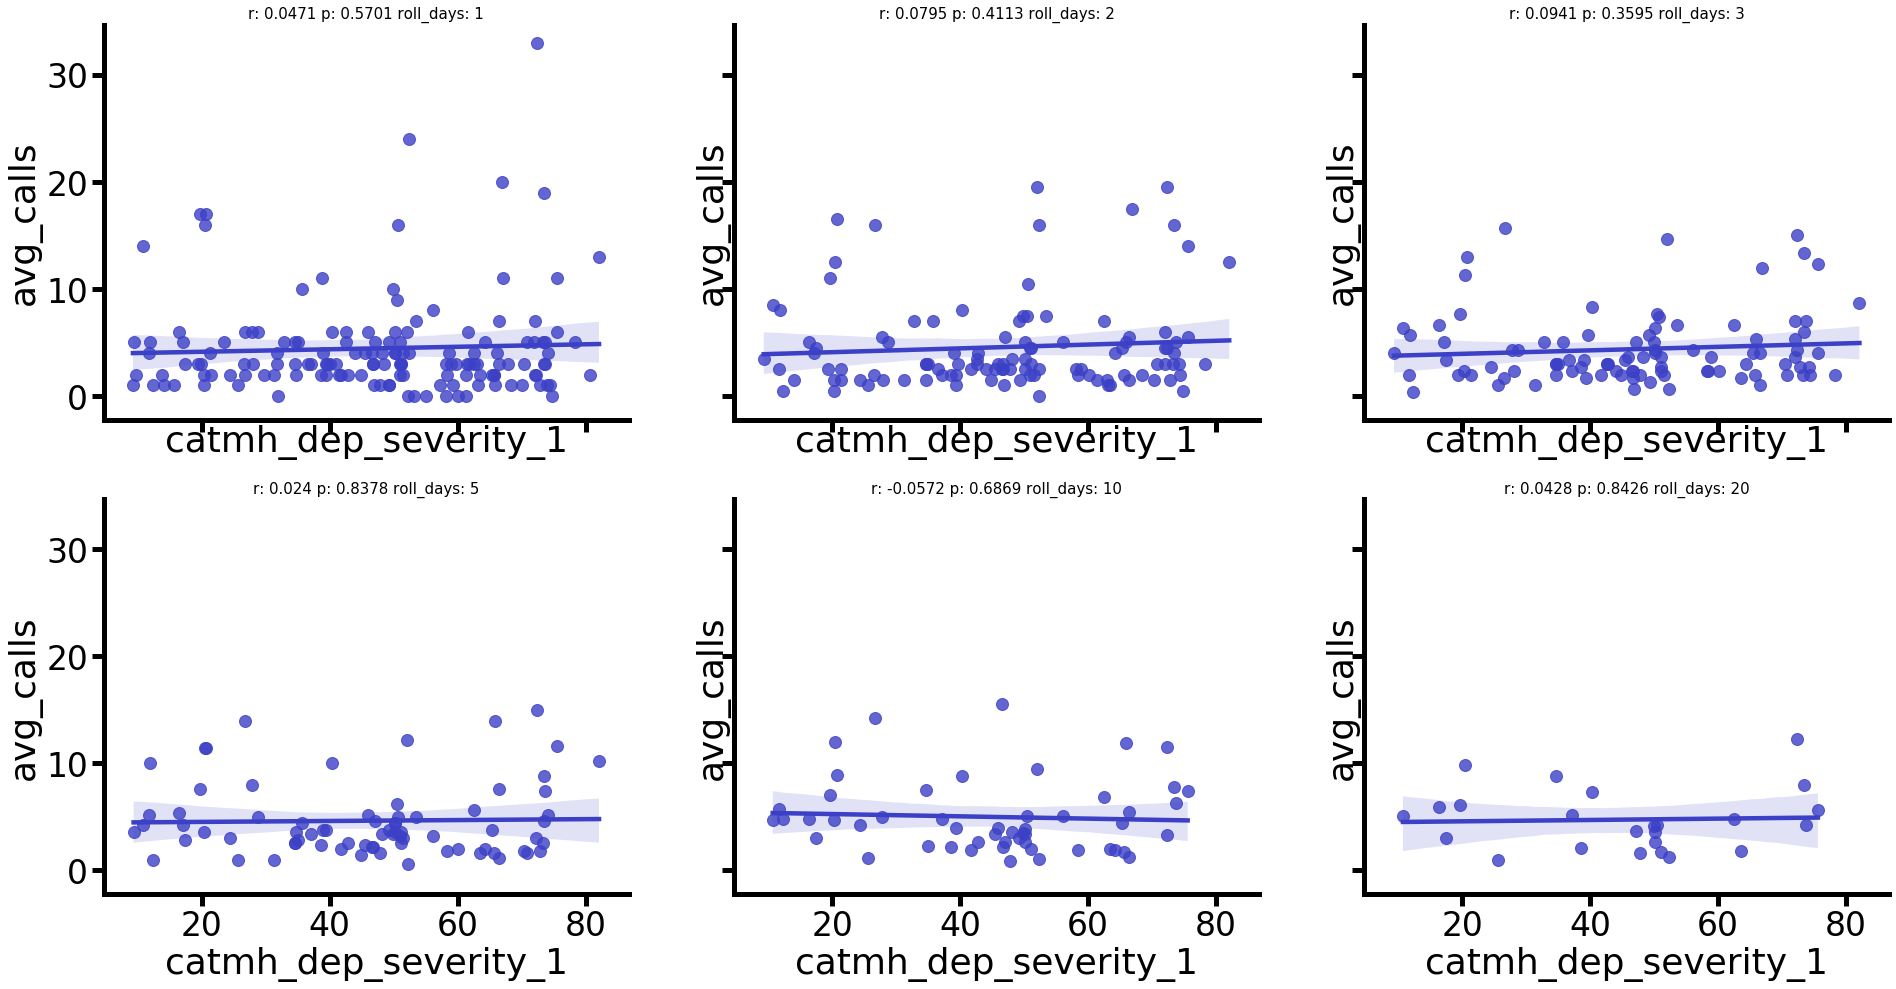

In [21]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(32, 16), sharex=True, sharey=True)
i=0
for roll_day in [1, 2, 3, 5, 10, 20]:
    with_rls = []
    for subject, s_df in data.sort_values(by='Date').groupby('subject_id'):
        s_df['avg_calls'] = s_df['outgoing_calls'].rolling(roll_day).mean()
        with_rls.append(s_df)
    rol_df = pd.concat(with_rls, sort=False)
    ax = axes.flatten()[i]
    sns.set_context(
        'poster',
        font_scale=1.5,
        rc={
            'axes.linewidth': 5,
            'xtick.major.width': 5,
            'ytick.major.width': 5,       
        }
    )
    no_na_rol = rol_df[['catmh_dep_severity_1', 'avg_calls']].dropna()
    r, p = stats.pearsonr(no_na_rol['catmh_dep_severity_1'], no_na_rol['avg_calls'])
    sns.regplot(
        data=rol_df,
        x='catmh_dep_severity_1',
        y='avg_calls',
        ax=ax,
        color=palette['catmh_dep_severity_1']
    )
    sns.despine()
    ax.set_title('r: ' + str(round(r,4)) + ' p: ' + str(round(p,4)) + ' roll_days: ' + str(roll_day), fontsize=15)
    i += 1